# xDrip+ Data Analysis for Gastroparesis Screening (XGastro-EDA)

## Introduction
This notebook demonstrates the processing and analysis of Continuous Glucose Monitoring (CGM) data from xDrip+ for potential gastroparesis screening applications. By carefully processing CGM data alongside meal and insulin records, we create a foundation for analyzing post-meal glucose response patterns.

### Project Context
Gastroparesis, a condition affecting gastric emptying, can be challenging to diagnose. Traditional screening methods often require specialized testing. This project explores the potential of using readily available CGM data to identify patterns that might indicate delayed gastric emptying.

### Data Source
- **xDrip+**: An open-source diabetes management application
- **Time Period**: June 2023 - September 2024
- **Key Components**:
 * CGM readings at 5-minute intervals
 * Meal records with carbohydrate quantities
 * Insulin dosing (basal and bolus)

### Project Objectives
1. **Data Integration**
  - Align CGM, meal, and insulin data to common timeline
  - Ensure data quality and completeness
  - Create robust meal analysis framework

2. **Quality Assurance**
  - Identify and characterize data gaps
  - Implement appropriate interpolation strategies
  - Maintain data integrity for clinical analysis

3. **Analysis Preparation**
  - Focus on significant meals (>20g carbs)
  - Create 4-hour post-meal analysis windows
  - Develop quality metrics for meal data assessment

### Notebook Structure
1. Data extraction and cleaning
2. Timeline alignment and gap analysis
3. Meal period identification and classification
4. Quality assessment and interpolation
5. Statistical validation
6. Preparation for further analysis

This notebook focuses on data preparation and quality assessment, laying the groundwork for subsequent analysis of post-meal glucose patterns.

# Required Libraries and Dependencies

This notebook uses several Python libraries for data manipulation, analysis, and visualization:

- **pandas**: Core data manipulation and analysis
- **numpy**: Numerical operations and array handling (imported in respective module)
- **matplotlib**: Data visualization and plotting
- **sqlalchemy**: Database connectivity and operations
- **ast**: Safe parsing of JSON-like strings (imported in respective module)
- **enum, dataclass, typing**: Type hinting and structured data classes (imported in respective module)
- **display**: Improved print options in Jupyter
- **pprint**: Improved print layout of nested data structures

Note: This project assumes you have these libraries installed. If needed, install via pip:
```pip install pandas numpy matplotlib sqlalchemy```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:95% !important; }</style>")) # Make Jupyter cells wider for better visuals
import pprint

# Import our created functions

We have chosen to keep the main code functionality seperate from this notebook for a couple of reasons, one being they keep our functionality modular, this is an advantage for multiple reasons including future use in other proejcts with minimal modifications. Other reasons being to keep the length of the notebook down and visually appealing as possible. This method will also allow for the repo to be cloned and used within your own projects, creating a tool for importing cleaning and using with your own data, in your own specific way and allowing for future expansion for other CGM device and data formats.

If you have an interest, all our python code can be found in our `src` directory, and we have implemented this jupyter book with hover tooltip functionality, this will show the linked python code for each function as the are being used by simply hovering over the link in the markdown cell prior to the function use. the functions will be shown in links using this format: Here's a function from 

[`my_module.py`](../src/my_module.py)

In [2]:
# Path modification used to allow Notebook access to src directory
import os
import sys
notebook_path = os.path.abspath('.')
project_root = os.path.join(notebook_path, '../../')
if project_root not in sys.path:
    sys.path.append(project_root)

# Preprocessing Module - Load, clean and align data
from src.preprocessing.loading import XDrip  
from src.preprocessing.cleaning import clean_classify_insulin, clean_classify_carbs, clean_glucose
from src.preprocessing.alignment import align_diabetes_data

# Analysis Module - Check and display data quality
from src.analysis.config import MealQuality, MealAnalysisConfig
from src.analysis.gaps import analyse_glucose_gaps
from src.analysis.insulin import analyse_insulin_over_time
from src.analysis.meals import analyse_meal_data, get_meal_statistics
from src.analysis.metrics import display_quality_metrics

# Visualisation Module - Format data for visual appeal in Jupyter
from src.visualisation.quality_dashboard import create_quality_dashboard
from src.visualisation.meal_statistics_dashboard import create_meal_statistics_dashboard
from src.visualisation.gap_dashboard import create_gap_dashboard


# Data Source: xDrip+ SQLite Database

This notebook begins by connecting to an xDrip+ SQLite database export. xDrip+ is an open-source diabetes management application that stores various diabetes-related data including glucose readings, treatments, and device status information.

## Database Connection
We establish a connection to the SQLite database and inspect its structure. The database contains 29 tables storing different aspects of diabetes management data:

Key tables for our analysis:
- **BgReadings**: Continuous glucose monitoring (CGM) data
- **Treatments**: Insulin doses and carbohydrate intake records
- **Calibration**: Sensor calibration events
- **Sensors**: CGM sensor information

[`XDrip`](../src/preprocessing/loading.py#L7)
[`get_table_names()`](../src/preprocessing/loading.py#L14)

In [3]:
# Path to your SQLite file
db_path = '../../data/export20240928-130349.sqlite'
data = XDrip(db_path) # Load db path into XDrip class - Class found in src directory
tables = data.get_table_names() # PPrint all table names in sqlite file - Function found in src directory

['APStatus',
 'Accuracy',
 'ActiveBgAlert',
 'ActiveBluetoothDevice',
 'AlertType',
 'BgReadings',
 'BgSendQueue',
 'BloodTest',
 'Calibration',
 'CalibrationRequest',
 'CalibrationSendQueue',
 'DesertSync',
 'HeartRate',
 'Libre2RawValue2',
 'Libre2Sensors',
 'LibreBlock',
 'LibreData',
 'Notifications',
 'PebbleMovement',
 'PenData',
 'Prediction',
 'Reminder',
 'SensorSendQueue',
 'Sensors',
 'TransmitterData',
 'Treatments',
 'UploaderQueue',
 'UserErrors',
 'android_metadata']


# Loading and Initial Data Processing

We extract three key datasets from the xDrip+ database and prepare them for analysis by:
1. Converting Unix timestamps to pandas datetime format
2. Setting timestamps as index for time-series analysis
3. Creating separate dataframes initially for:
  - Blood glucose readings
  - Treatment records (insulin & carbohydrates)

## Data Loading Process
Each table requires the same preprocessing steps:
- SQL to pandas DataFrame conversion
- Timestamp conversion from milliseconds
- Index creation from timestamp

You can check out the full implementation in the src directory.
Let's examine the structure of our blood glucose data:

[`load_glucose_df()`](../src/preprocessing/loading.py#L19)
[`load_treatment_df()`](../src/preprocessing/loading.py#L31)

In [4]:
bg_df = data.load_glucose_df() # Load glucose data into a pandas dataframes and set timestamp as index - Function found in src directory

treatment_df = data.load_treatment_df() # Load glucose data into a pandas dataframes and set timestamp as index - Function found in src directory

In [5]:
# Explore the first few rows of the blood glucose table
bg_df.head()

,_id,a,age_adjusted_raw_value,b,c,calculated_value,calculated_value_slope,calibration,calibration_flag,calibration_uuid,...,ra,raw_calculated,raw_data,rb,rc,sensor,sensor_uuid,source_info,time_since_sensor_started,uuid
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-03 22:31:05.757,72464,1.245412e-13,190.235280,-0.419946,3.540085e+11,133.923468,-0.000035,559.0,0,cba43ee7-5a7c-47e7-beb5-a5d7c211e64b,...,1.620198e-13,0.0,190.235280,-0.546322,4.605416e+11,42,73b87f32-2b6b-47c9-b2bc-9283632d169a,None,1.211123e+09,a63f2267-5f99-4663-8714-7146835e118c
2023-06-03 22:36:06.812,72465,7.766019e-12,178.352928,-26.184433,2.207130e+13,124.789758,-0.000030,559.0,0,cba43ee7-5a7c-47e7-beb5-a5d7c211e64b,...,1.010308e-11,0.0,178.352928,-34.064212,2.871330e+13,42,73b87f32-2b6b-47c9-b2bc-9283632d169a,None,1.211424e+09,d1386140-bdfe-4bd3-802e-9b406cf320c2
2023-06-03 22:41:09.457,72466,2.847681e-11,173.176458,-96.014259,8.093196e+13,120.810715,-0.000013,559.0,0,cba43ee7-5a7c-47e7-beb5-a5d7c211e64b,...,3.704645e-11,0.0,173.176458,-124.908189,1.052871e+14,42,73b87f32-2b6b-47c9-b2bc-9283632d169a,None,1.211727e+09,1f24e9fc-b7f5-4ae9-a5ca-2ba50b8d3e09
2023-06-03 22:50:16.249,72467,-1.041753e-11,157.529400,35.124388,-2.960690e+13,108.783156,-0.000022,559.0,0,cba43ee7-5a7c-47e7-beb5-a5d7c211e64b,...,-1.355251e-11,0.0,157.529400,45.694502,-3.851661e+13,42,73b87f32-2b6b-47c9-b2bc-9283632d169a,None,1.212273e+09,b6395bd2-e2fb-4471-845a-ad2f2efb5e66
2023-06-03 22:55:15.702,72468,-3.626429e-12,147.764695,12.227082,-1.030639e+13,101.277236,-0.000025,559.0,0,cba43ee7-5a7c-47e7-beb5-a5d7c211e64b,...,-4.717744e-12,0.0,147.764695,15.906624,-1.340793e+13,42,73b87f32-2b6b-47c9-b2bc-9283632d169a,None,1.212573e+09,3cdb52ca-e4e3-43d0-8274-f16c70c24513


# Treatment Data Preprocessing: Insulin Classification

This function implements a sophisticated insulin classification algorithm for diabetes treatment data. The classification process handles both labeled and unlabeled insulin entries, using a combination of explicit insulin types and quantity-based rules.

## Classification Rules
1. **Labeled Insulin**
  - Novorapid → Bolus insulin
  - Levemir → Basal insulin

2. **Unlabeled Insulin**
  - ≤ 8 units → Classified as Bolus
  - 8-15 units → Classified as Basal
  - >15 units → Dropped (likely data entry errors)

## Function Process
- Creates separate columns for bolus and basal insulin
- Processes JSON metadata for labeled entries
- Applies rule-based classification for unlabeled entries
- Maintains data integrity by dropping suspicious entries


[`clean_classify_insulin()`](../src/preprocessing/cleaning.py#L6)

In [6]:
insulin_df = clean_classify_insulin(treatment_df) # Function in source directory

# Analysing Insulin Usage Patterns Over Time

This analysis examines the temporal patterns in insulin usage, providing insights into treatment consistency and data quality. The function performs both data analysis and visualization, helping identify trends and potential data collection issues.

## Analysis Components
1. **Temporal Aggregation**
  - Groups data by month
  - Processes JSON metadata for insulin types
  - Calculates usage percentages for different insulin types

2. **Insulin Classification**
  - Novorapid (rapid-acting insulin)
  - Levemir (long-acting insulin)
  - Other insulin types
  - Unspecified entries

## Visualisation
The function generates two complementary plots:
1. **Stacked Area Chart**
  - Shows relative distribution of insulin types
  - Uses consistent color coding (Orange: Novorapid, Green: Levemir)
  - Reveals changes in recording practices

2. **Entry Count Timeline**
  - Displays total monthly entries
  - Helps identify data collection gaps or inconsistencies


[`analyse_insulin_over_time()`](../src/analysis/insulin.py#L19)

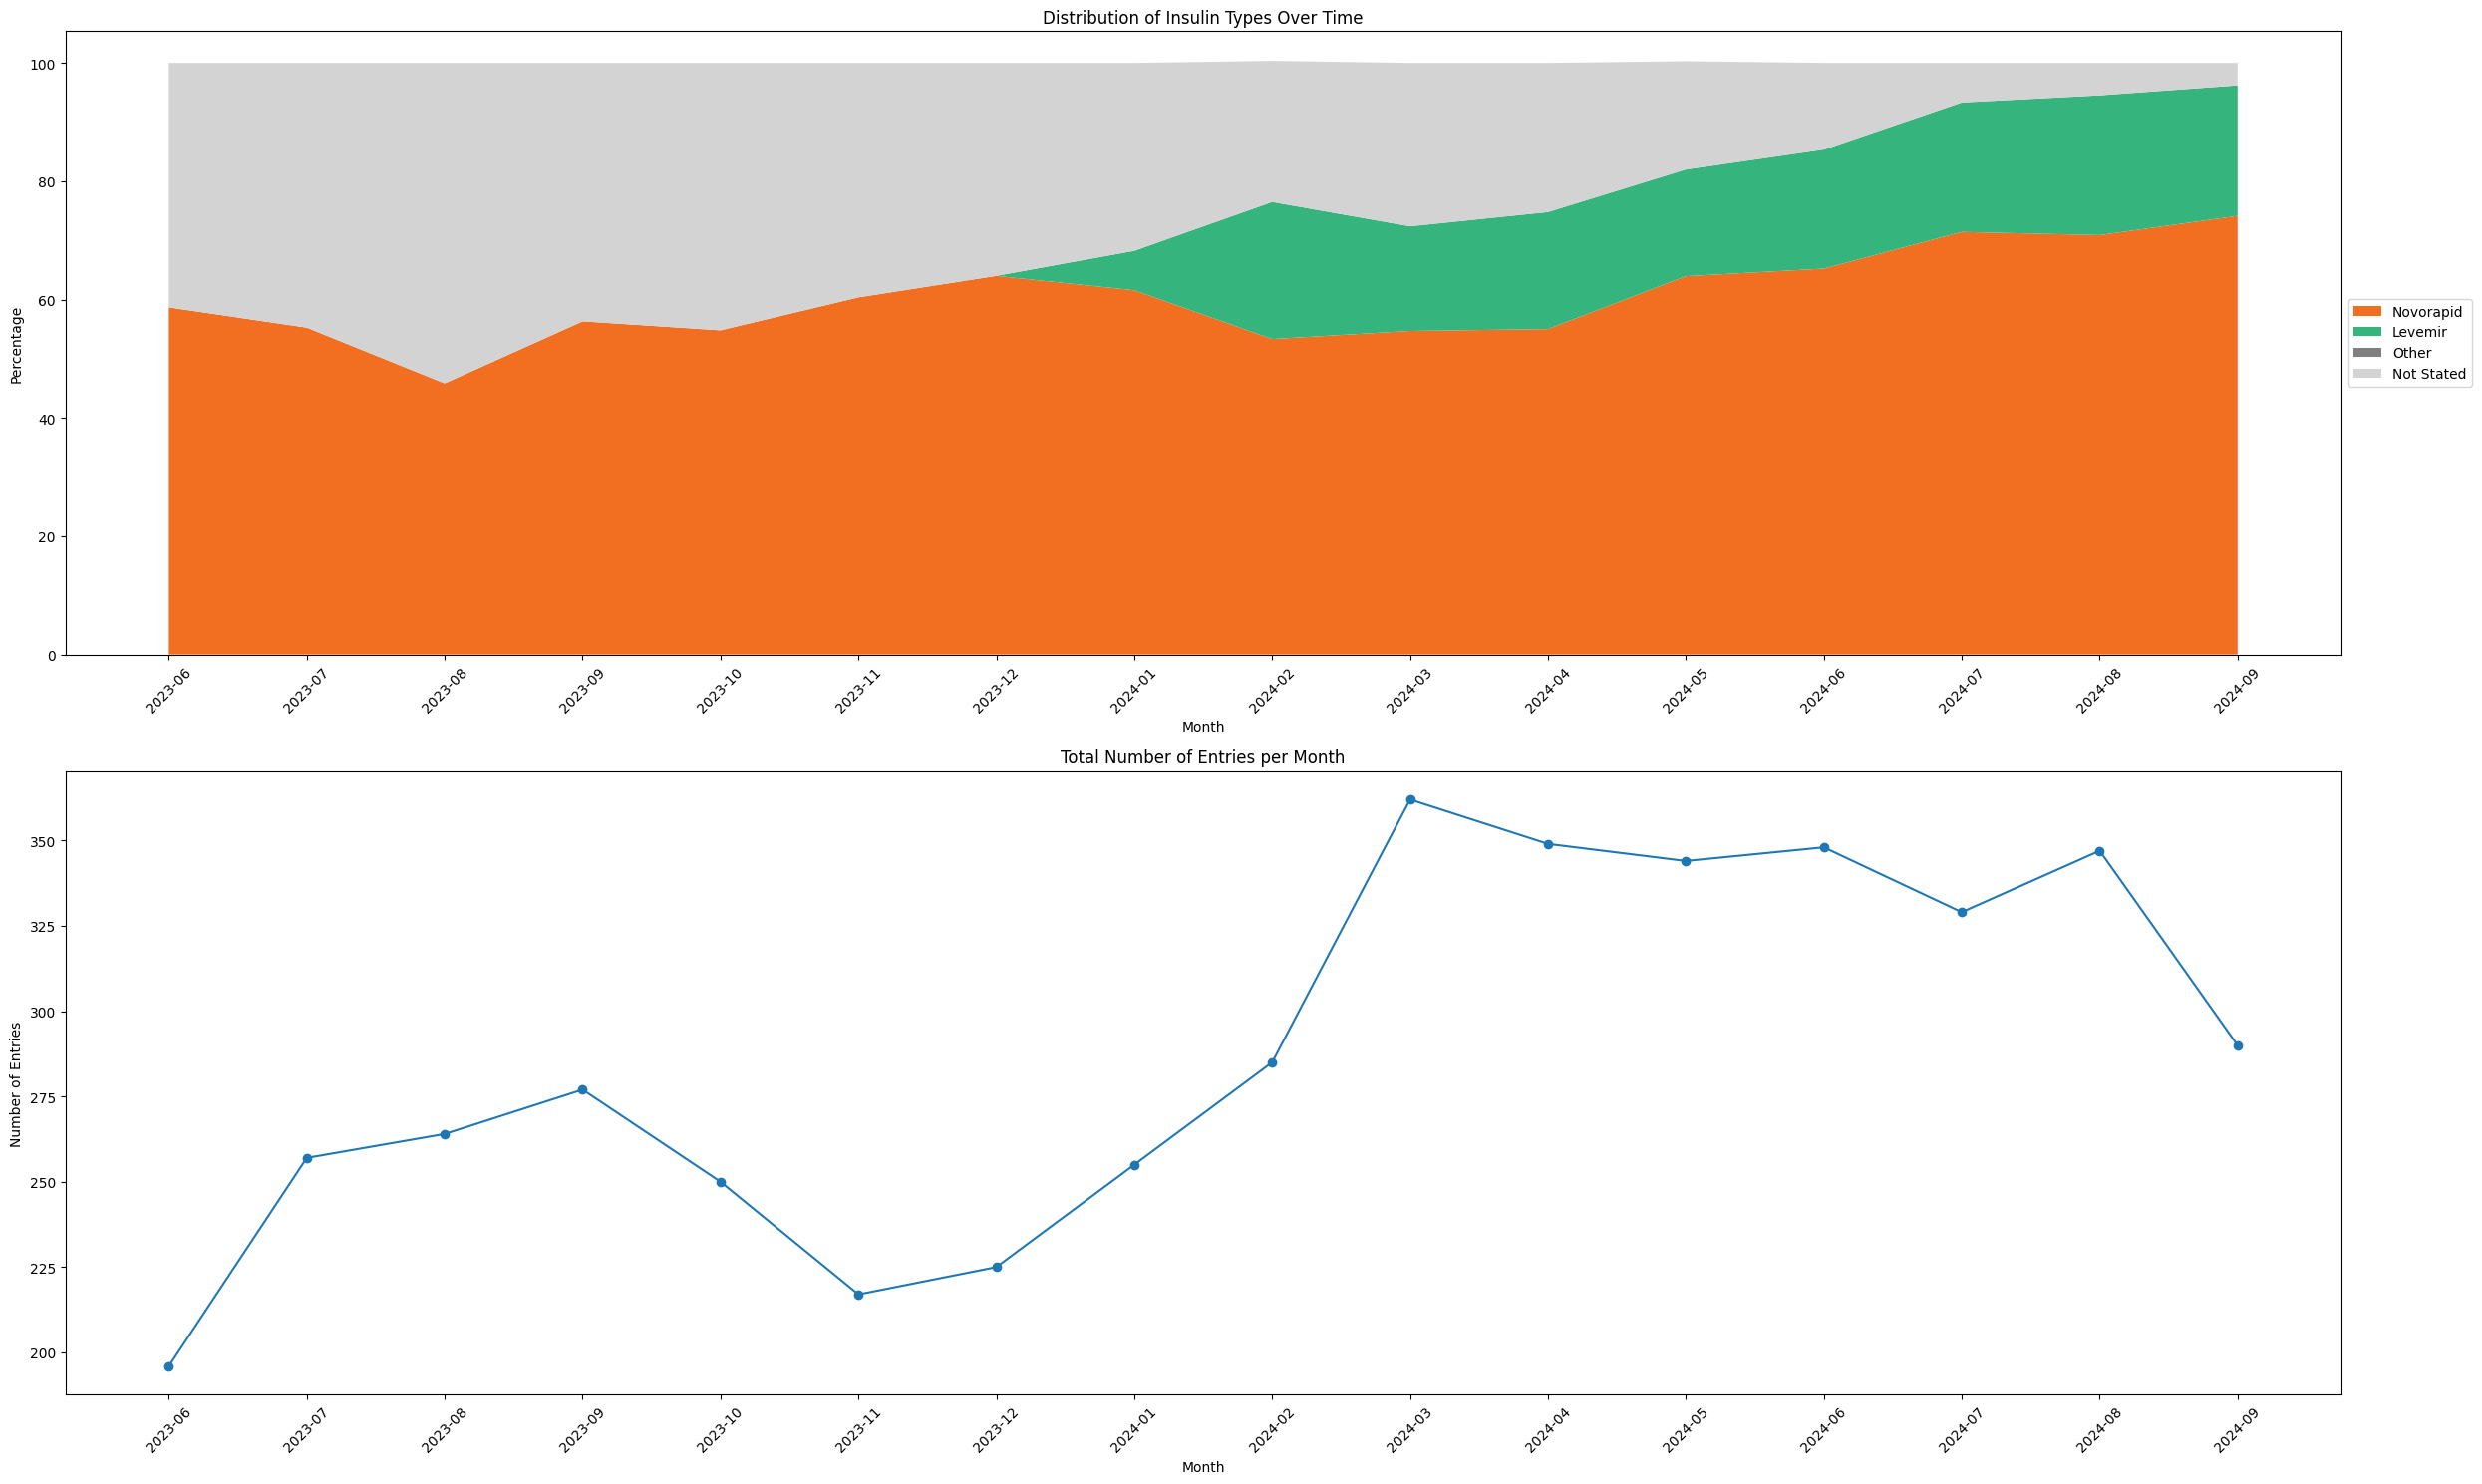

In [7]:
plot, insulin_counts = analyse_insulin_over_time(insulin_df) # Function in source directory
plot.show()

# Data Validation: Raw Insulin Distribution

Before proceeding with our cleaned and classified insulin data, we visualize the raw insulin entries to:
1. Verify the range of insulin values
2. Identify potential outliers
3. Check temporal distribution of entries
4. Validate our classification thresholds (8u for bolus, 15u for basal)

The scatter plot provides a quick visual validation that our insulin classification function's assumptions align with the actual data patterns.

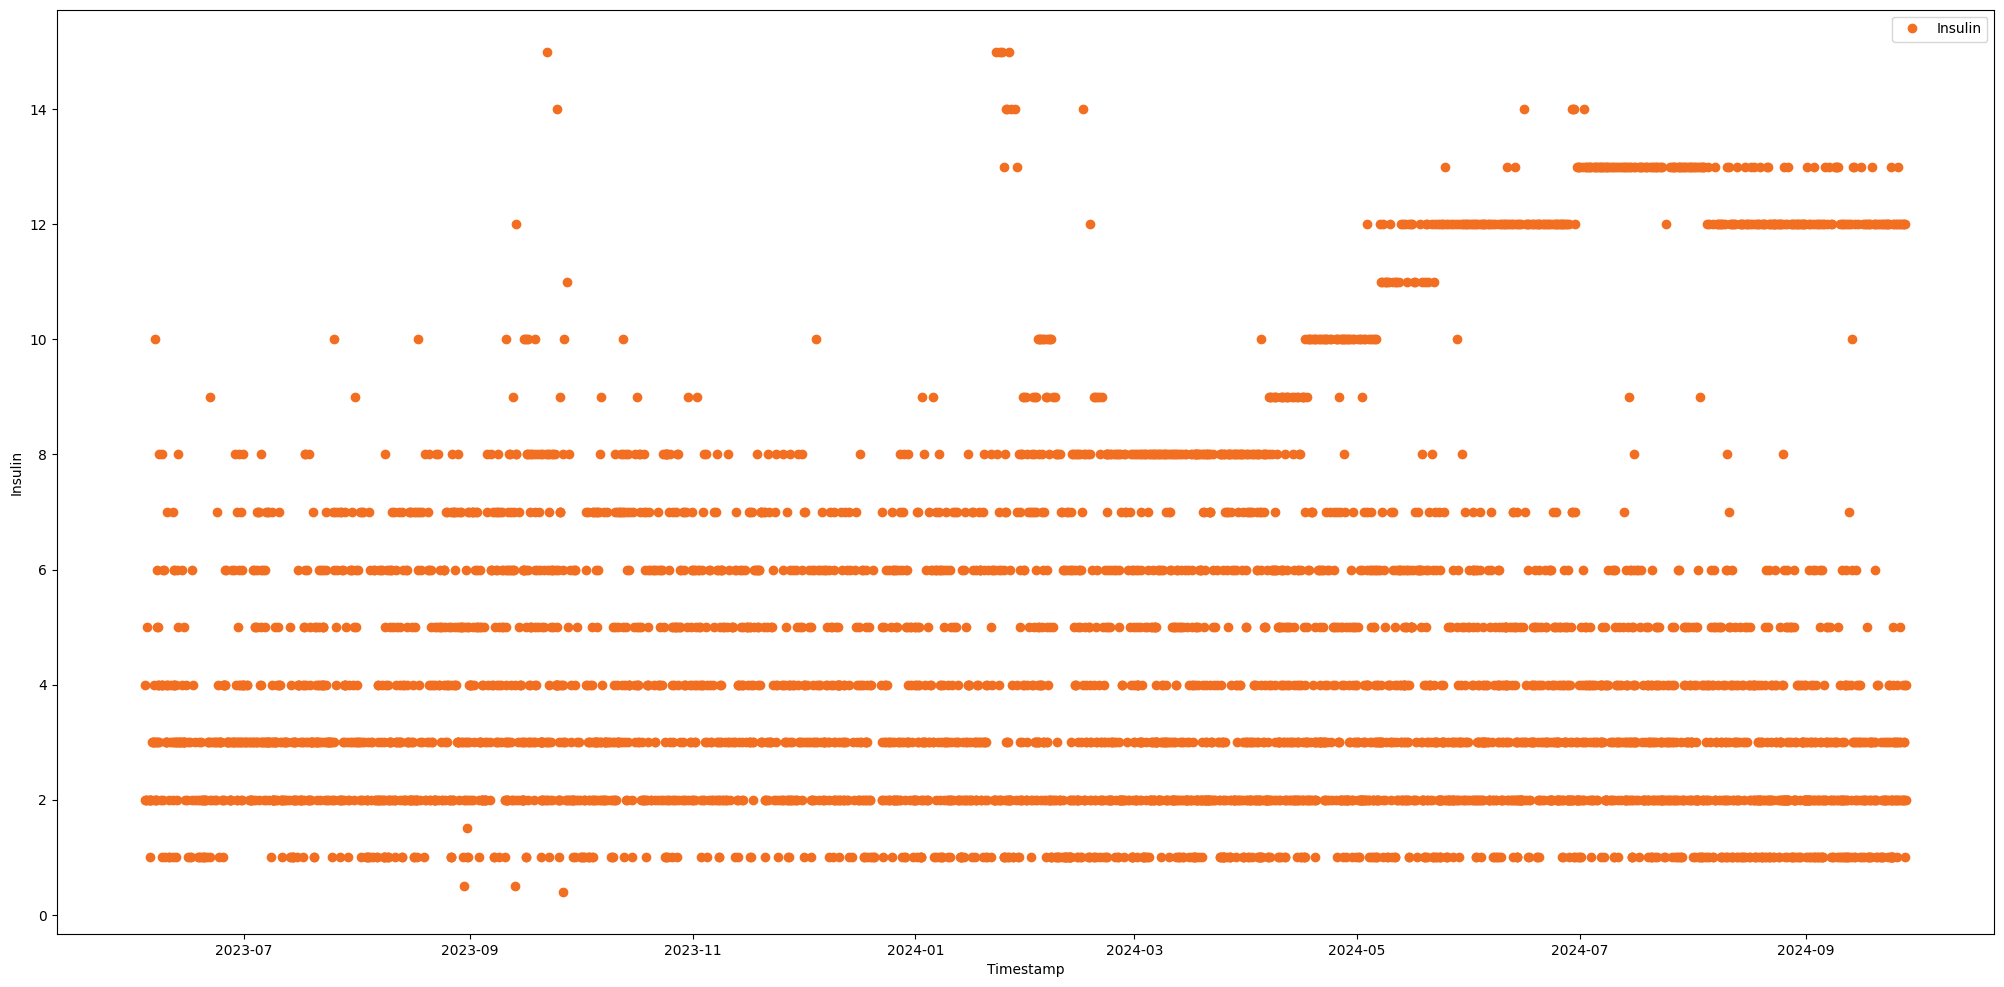

In [8]:
# Make plot 25 x 12
plt.figure(figsize=(25, 12))

plt.plot(insulin_df['insulin'], label='Insulin', marker='o', linestyle = 'None', color='#F26F21')

# Add labels, title, and legend
plt.xlabel('Timestamp')
plt.ylabel('Insulin')
plt.legend()

plt.show()

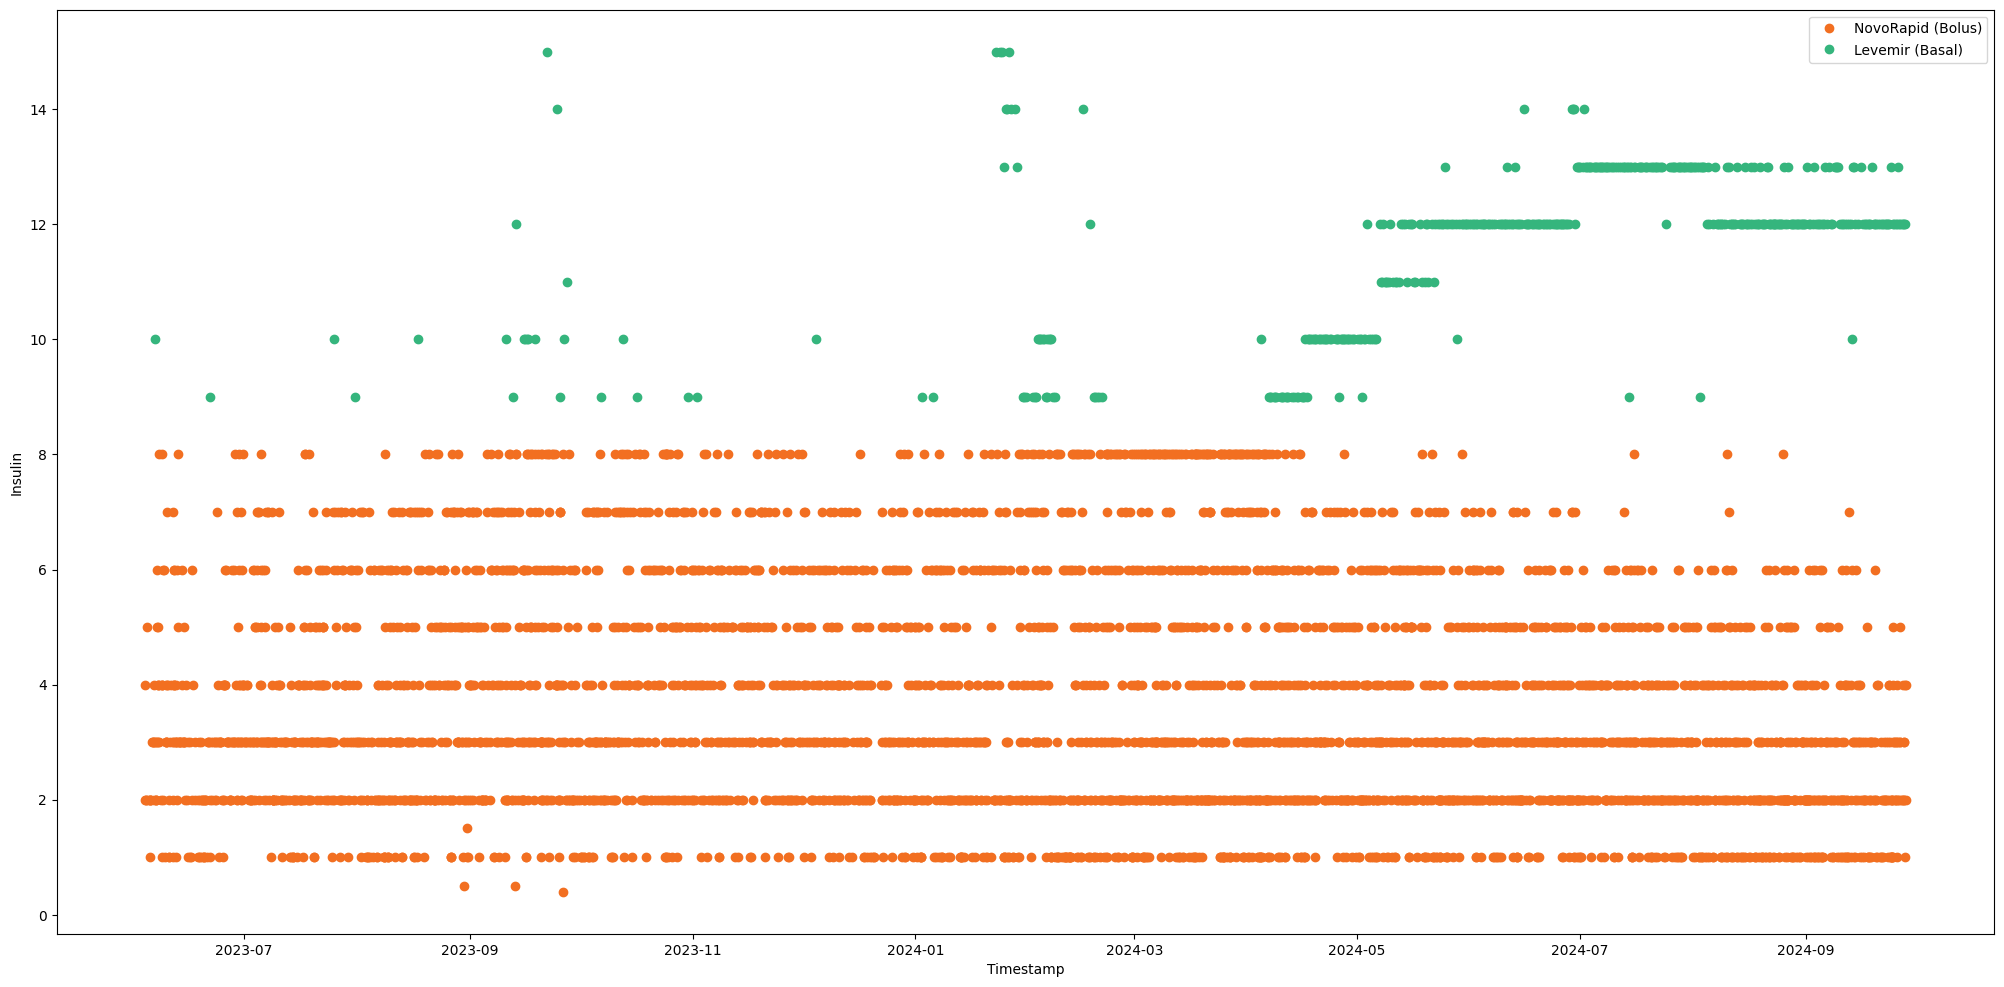

In [9]:
# Make plot 25 x 12
plt.figure(figsize=(25, 12))

# Create masks for NovoRapid (bolus) and Levemir (basal)
bolus_mask = insulin_df['bolus'] >0.0
basal_mask = insulin_df['basal']> 0.0

# Plot bolus (NovoRapid) points
plt.plot(
    np.array(insulin_df[bolus_mask].index),  # Convert index to NumPy array
    np.array(insulin_df[bolus_mask]['insulin']),  # Convert insulin values to NumPy array
    label='NovoRapid (Bolus)', 
    marker='o', 
    linestyle='None',  # No line connecting points
    color='#F26F21'  # NovoRapid orange
)

# Plot basal (Levemir) points
plt.plot(
    np.array(insulin_df[basal_mask].index),  # Convert index to NumPy array
    np.array(insulin_df[basal_mask]['insulin']),  # Convert insulin values to NumPy array
    label='Levemir (Basal)', 
    marker='o', 
    linestyle='None',  # No line connecting points
    color='#35b57d'  # Levemir green
)

# Add labels, title, and legend
plt.xlabel('Timestamp')
plt.ylabel('Insulin')
plt.legend()

plt.show()

# Refined Insulin Dataset Structure

After cleaning and classification, we isolate our two key insulin variables (bolus and basal) and examine the resulting dataset structure. This inspection helps:

1. **Verify Data Processing**
  - Confirm successful separation of insulin types
  - Check data types and memory usage
  - Review null values if any

2. **Statistical Overview**
  - Distribution of both insulin types
  - Typical dosing ranges
  - Identify any remaining outliers

The .info() shows our dataframe structure while .describe() provides key statistical measures.


In [10]:
insulin_df = insulin_df[['bolus', 'basal']]

In [11]:
insulin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4595 entries, 2023-06-03 23:58:08.909000 to 2024-09-28 09:44:00.948000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bolus   4595 non-null   float64
 1   basal   4595 non-null   float64
dtypes: float64(2)
memory usage: 236.7 KB


In [12]:
insulin_df.describe()

,bolus,basal
count,4595.000000,4595.000000
mean,3.213036,1.182372
std,2.170215,3.551143
min,0.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,0.000000
max,8.000000,15.000000


# Carbohydrate Data Preprocessing

A straightforward but essential cleaning step for carbohydrate data. This function:
1. Creates a safe copy of the original data
2. Removes trivial carbohydrate entries (<1g)
3. Maintains original timestamp indexing

## Rationale
- Entries below 1g are likely recording errors or insignificant for meal analysis
- Clean dataset focuses on meaningful carbohydrate intake events
- Preserves original data structure for later meal impact analysis

[`clean_classify_carbs()`](../src/preprocessing/cleaning.py#L62)

In [13]:
carb_df = clean_classify_carbs(treatment_df) # Function in source directory

# Refined Carbohydrate Dataset Structure

After cleaning our carbohydrates dataset, we simply wish to keep the index and carbs column.


In [14]:
# Drop all columns except carbohydrate
carb_df = carb_df[['carbs']]
carb_df

,carbs
timestamp,
2023-06-04 15:07:19.574,15.0
2023-06-05 08:38:31.044,11.5
2023-06-05 19:47:28.229,10.0
2023-06-05 20:11:25.671,2.0
2023-06-06 09:23:28.065,13.0
...,...
2024-09-27 19:35:57.790,20.0
2024-09-27 20:09:48.635,25.0
2024-09-28 02:00:14.692,16.0


# Visual Validation: Carbohydrate Distribution

Following our carbohydrate data cleaning, we visualize the temporal distribution and magnitude of carbohydrate entries to:

1. Confirm removal of sub-1g entries
2. Examine the range of carbohydrate values
3. Check recording frequency and patterns
4. Identify any potential outliers requiring attention

The scatter plot representation helps validate our minimal cleaning approach and provides insight into meal recording patterns.

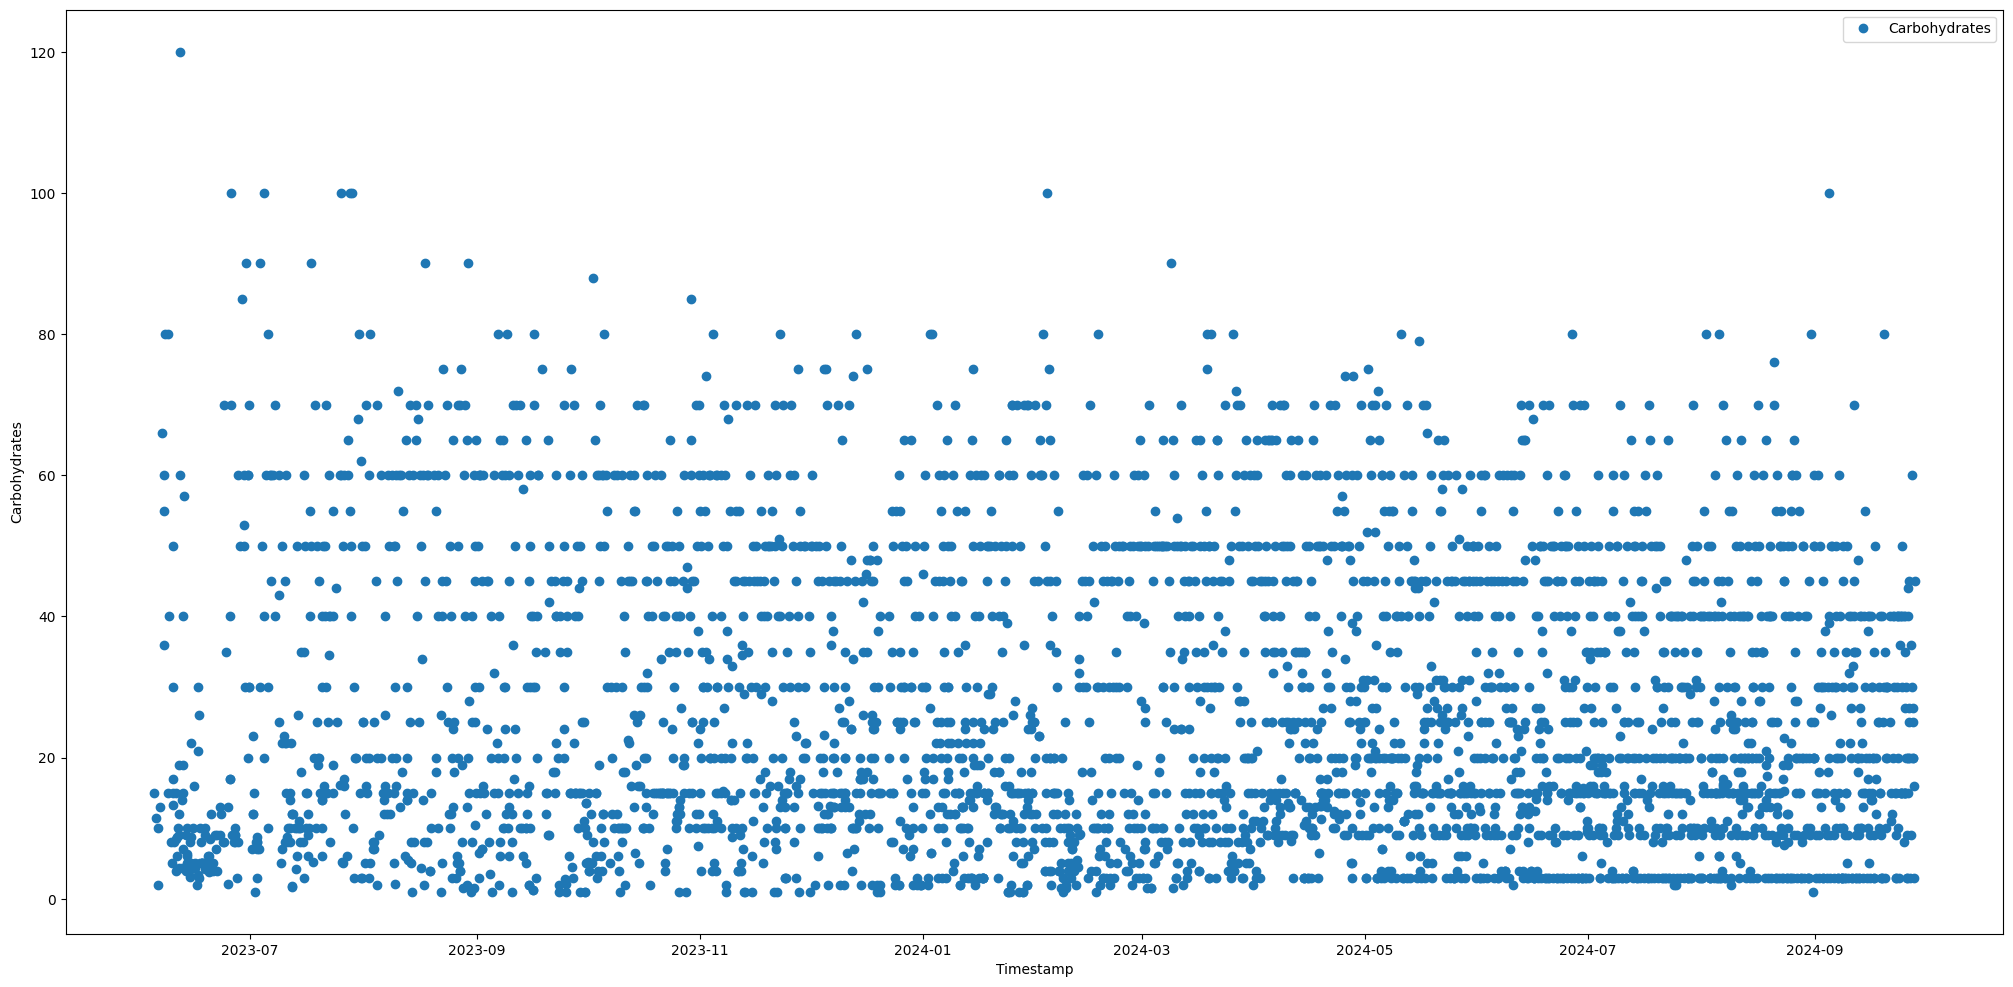

In [15]:
# Make plot 25 x 12
plt.figure(figsize=(25, 12))

plt.plot(carb_df['carbs'], label='Carbohydrates', marker='o', linestyle = 'None')

# Add labels, title, and legend
plt.xlabel('Timestamp')
plt.ylabel('Carbohydrates')
plt.legend()

plt.show()

# Carbohydrate Dataset Summary

After basic cleaning, we examine the carbohydrate dataset structure and statistics to:

1. **Verify Dataset Properties**
  - Confirm single carbohydrate column retention
  - Check data type consistency
  - Review number of recorded meals

2. **Statistical Distribution**
  - Typical meal carbohydrate content
  - Range of carbohydrate values
  - Help validate typical meal size assumptions

The .info() provides structure verification while .describe() shows the statistical distribution of meal carbohydrates.


In [16]:
carb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3507 entries, 2023-06-04 15:07:19.574000 to 2024-09-28 10:16:10.065000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   carbs   3507 non-null   float64
dtypes: float64(1)
memory usage: 54.8 KB


In [17]:
carb_df.describe()

,carbs
count,3507.000000
mean,26.377887
std,20.254482
min,1.000000
25%,10.000000
50%,20.000000
75%,40.000000
max,120.000000


# Blood Glucose Data Preprocessing

This cleaning function prepares blood glucose data for analysis by implementing essential clinical and analytical standards:

## Cleaning Steps
1. **Unit Standardization**
  - Renames 'calculated_value' to 'mg_dl' for clarity
  - Creates 'mmol_l' column (standard international units)
  - Conversion factor: mg/dL × 0.0555 = mmol/L

2. **Clinical Range Enforcement**
  - Lower bound: 39.64 mg/dL (2.2 mmol/L)
  - Upper bound: 360.36 mg/dL (20.0 mmol/L)
  - Values outside range clipped to these limits

3. **Data Simplification**
  - Retains only essential columns
  - Preserves timestamp index
  - Maintains dual unit representation

## Rationale
- Range limits reflect typical CGM sensor capabilities
- Dual units support international analysis
- Simplified structure focuses on key metrics


[`clean_glucose()`](../src/preprocessing/cleaning.py#L75)

In [18]:
glucose_df = clean_glucose(bg_df) # Function in source directory

# Blood Glucose Data Visualization

We examine the glucose data through two complementary visualizations to validate our cleaning process and understand data patterns:

## Full Dataset Scatter Plot
- Shows complete temporal distribution
- Validates clipping of extreme values
- Reveals overall data density
- Highlights any major gaps

## Recent 90-Day Time Series
- Focused view of latest 90 days (25,920 points at 5-min intervals)
- Connected line plot shows glucose trends
- More detailed examination of recent monitoring
- Better visualization of daily patterns

## Recent 48-Hour Time Series
- Focused view of latest 48 Hours (576 points at 5-min intervals)
- Connected line plot shows glucose trends
- More detailed examination of recent monitoring
- Better visualization of daily patterns
The contrast between these views helps validate both long-term data collection and recent monitoring quality.

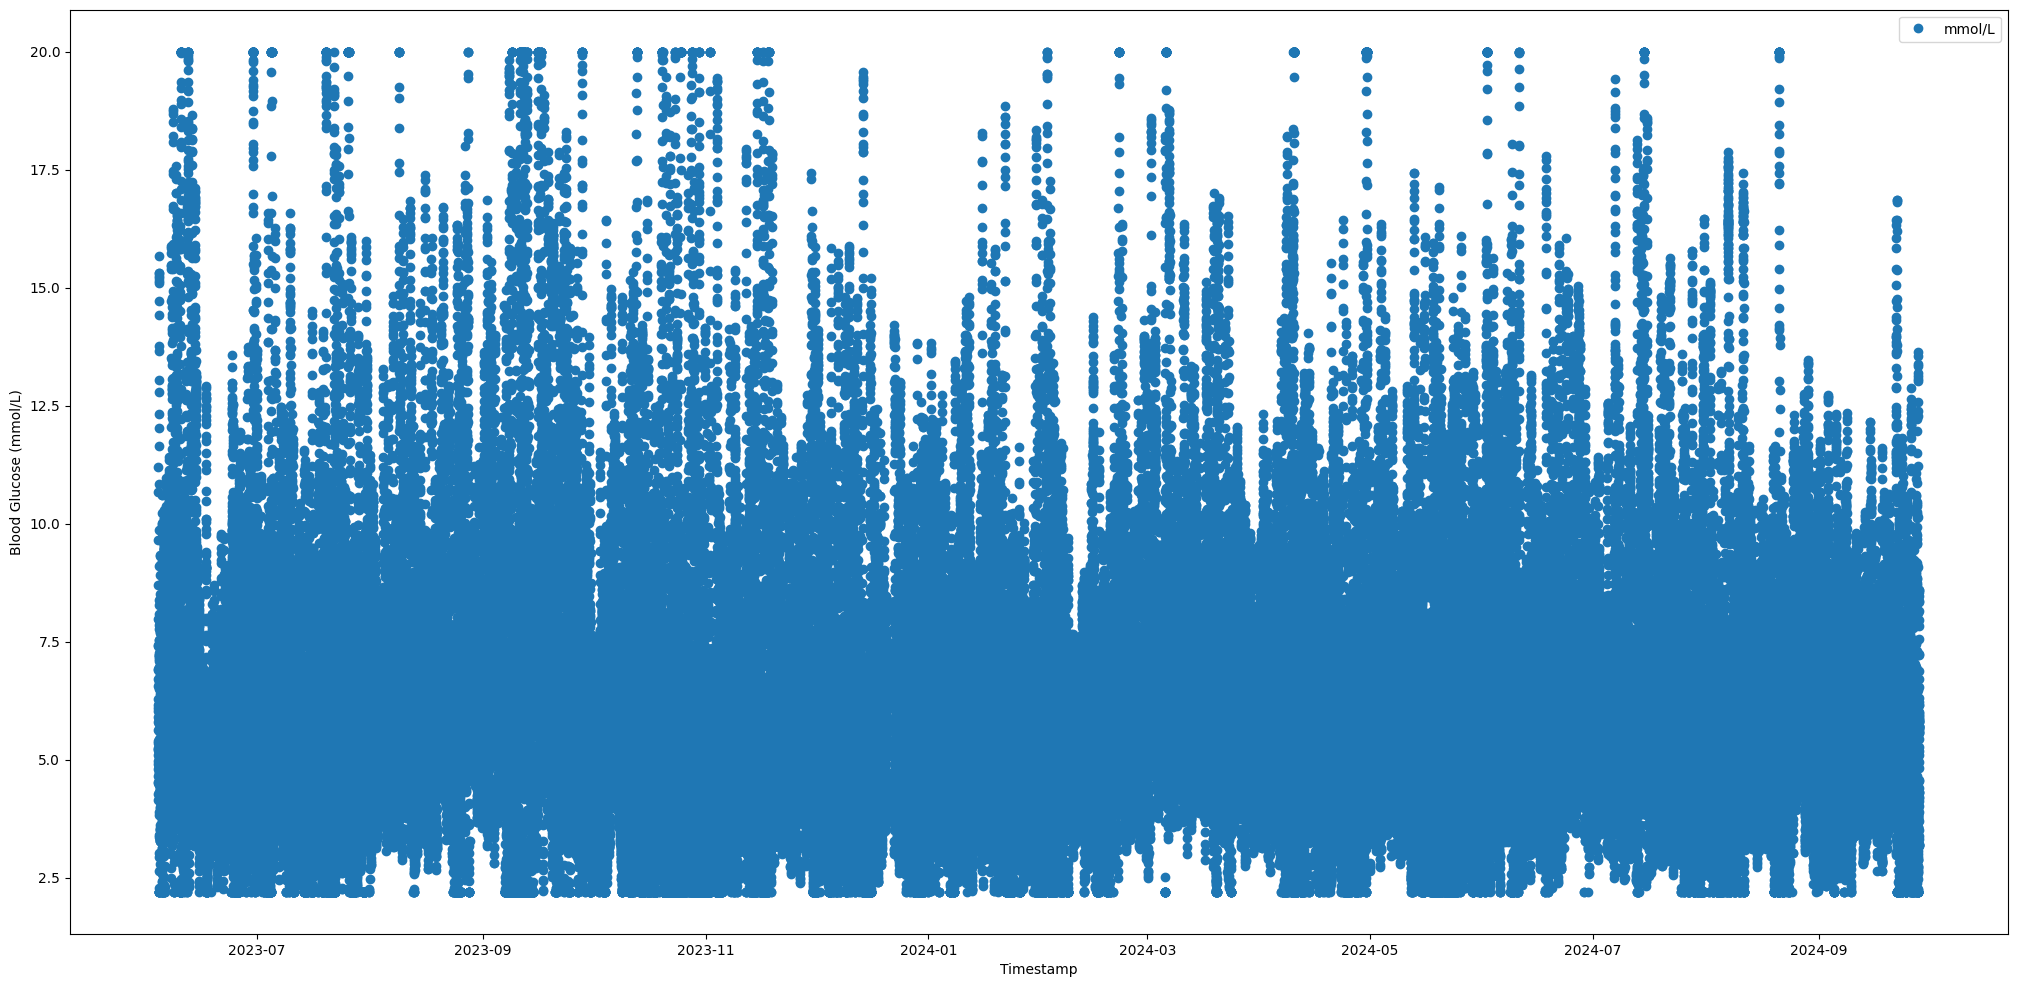

In [19]:
# Make plot 25 x 12
plt.figure(figsize=(25, 12))

plt.plot(glucose_df['mmol_l'], label='mmol/L', marker='o', linestyle = 'None')

# Add labels, title, and legend
plt.xlabel('Timestamp')
plt.ylabel('Blood Glucose (mmol/L)')
plt.legend()

plt.show()

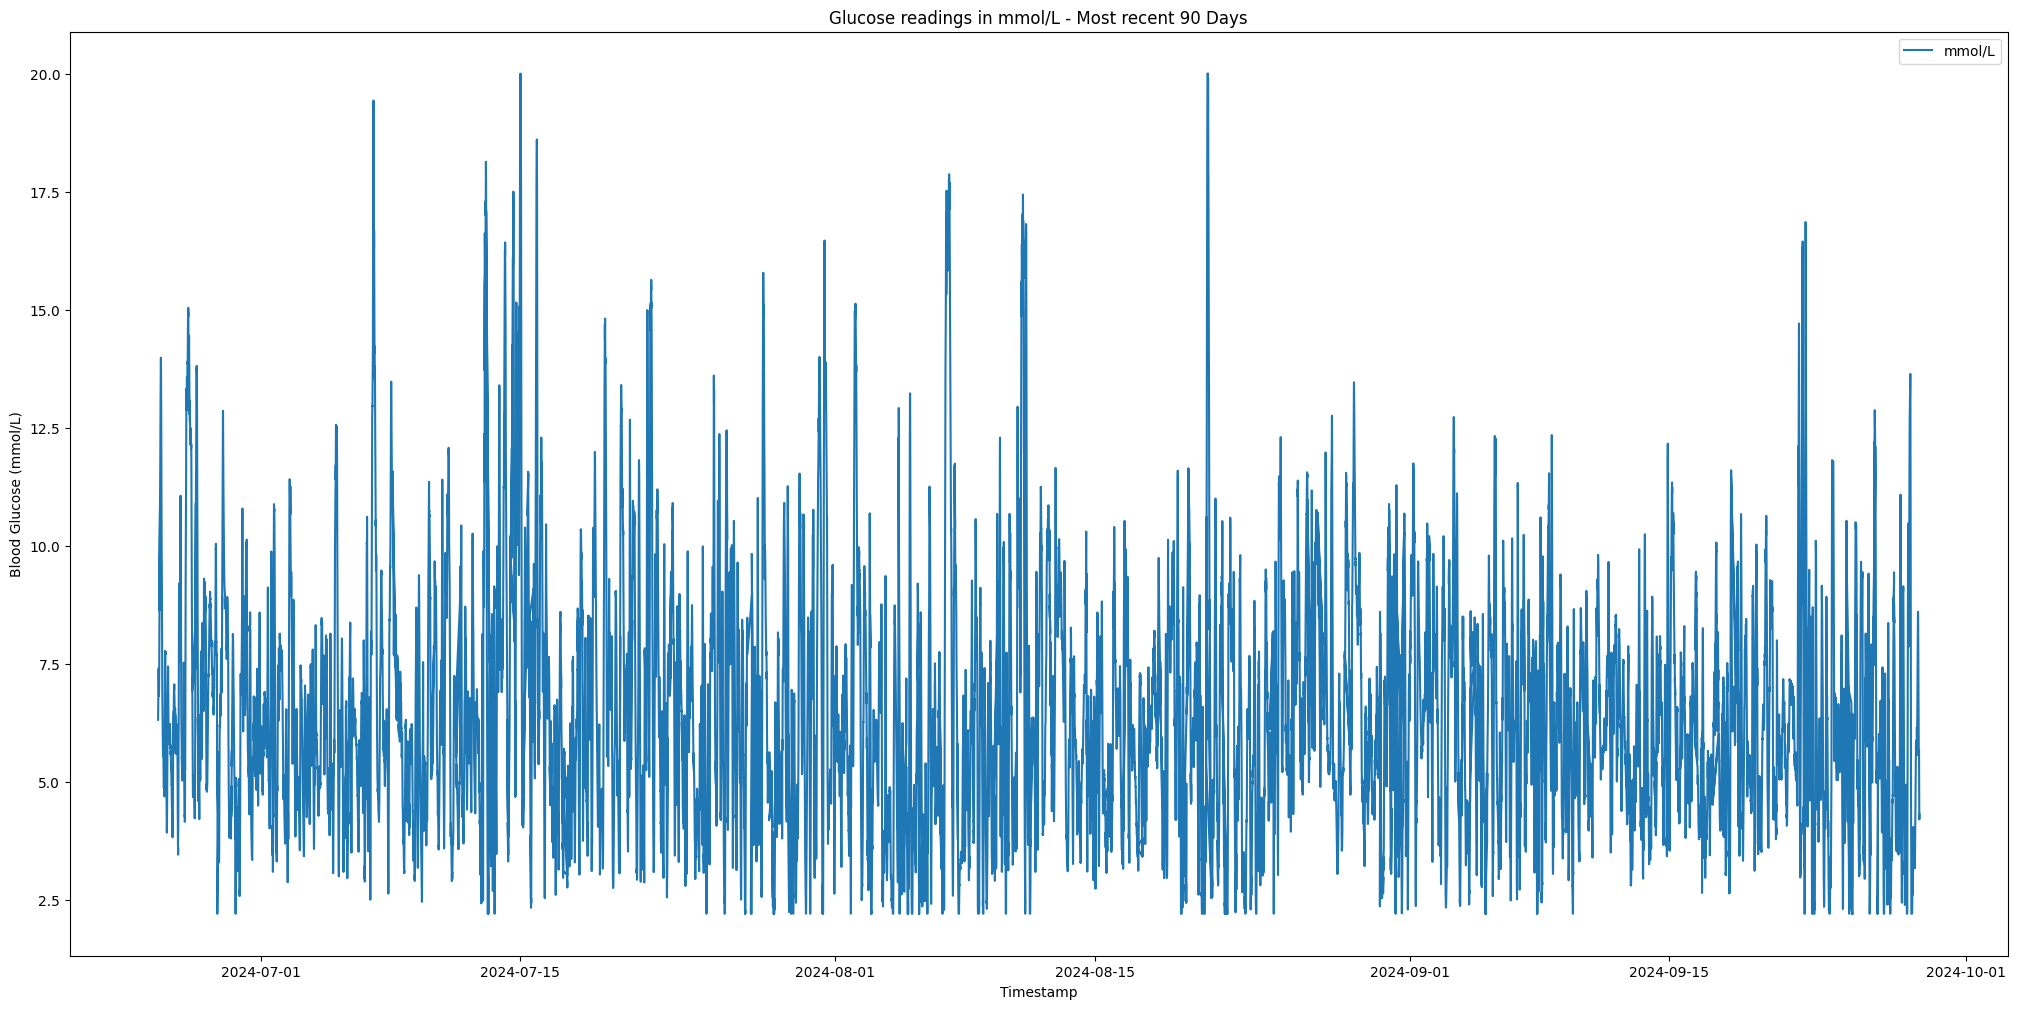

In [20]:
# Display most recent 90 days of glucose readings in mmol/L
last_90 = glucose_df[-25920:]

# Make plot 25 x 12
plt.figure(figsize=(25, 12))

plt.plot(last_90['mmol_l'], label='mmol/L')

# Add labels, title, and legend
plt.title('Glucose readings in mmol/L - Most recent 90 Days')
plt.xlabel('Timestamp')
plt.ylabel('Blood Glucose (mmol/L)')
plt.legend()

plt.show()

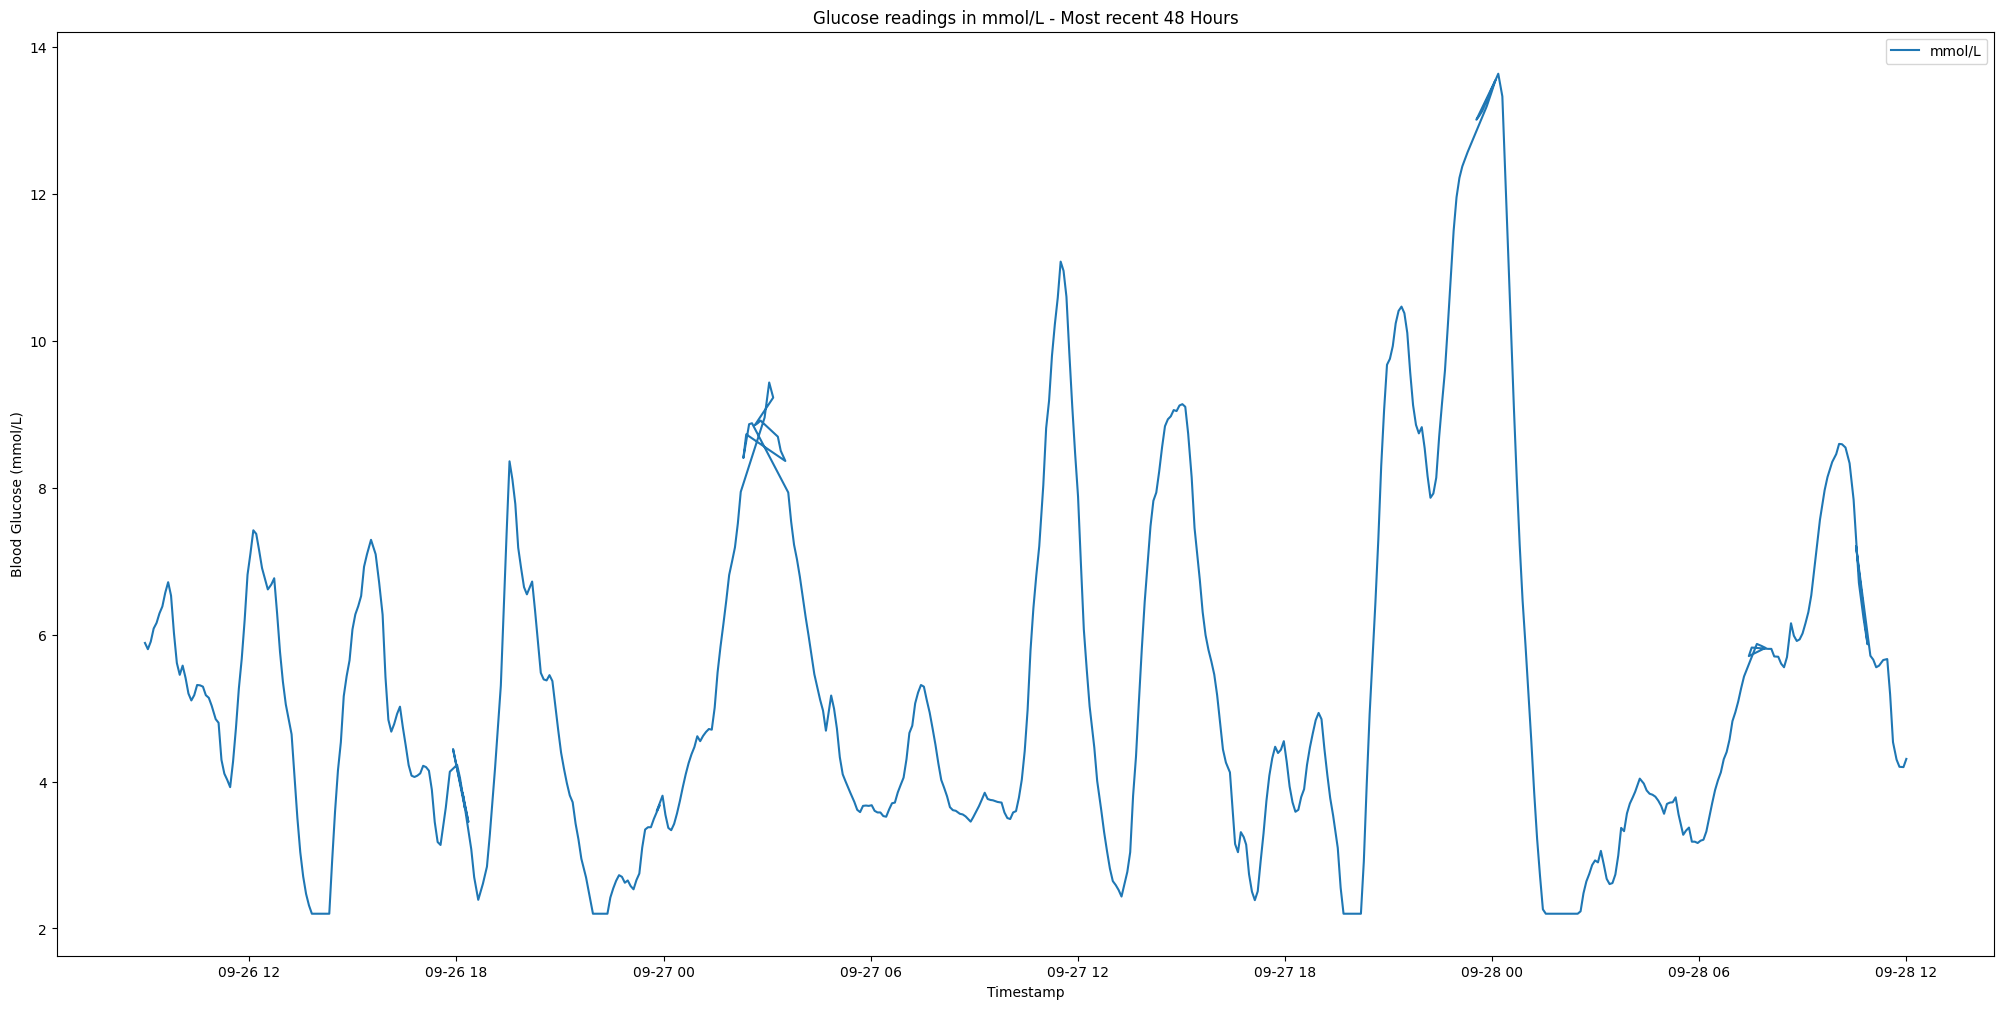

In [21]:
# Display most recent 48 Hours of glucose readings in mmol/L
last_48h = glucose_df[-576:]

# Make plot 25 x 12
plt.figure(figsize=(25, 12))

plt.plot(last_48h['mmol_l'], label='mmol/L')

# Add labels, title, and legend
plt.title('Glucose readings in mmol/L - Most recent 48 Hours')
plt.xlabel('Timestamp')
plt.ylabel('Blood Glucose (mmol/L)')
plt.legend()

plt.show()

We can see that the last 48 hour graph shows messy lines especially around 3 am, this could be due to incosistent gap sizes causing the lines to dilate and contract depending on the size of the gap. We will visualise this again after aligning our datasets to regular 5-minute intervals.

In [22]:
glucose_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132658 entries, 2023-06-03 22:31:05.757000 to 2024-09-28 12:00:32.280000
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mg_dl   132658 non-null  float64
 1   mmol_l  132658 non-null  float64
dtypes: float64(2)
memory usage: 7.1 MB


In [23]:
glucose_df.describe()

,mg_dl,mmol_l
count,132658.000000,132658.000000
mean,118.803722,6.593607
std,53.421262,2.964880
min,39.640000,2.200020
25%,81.721612,4.535549
50%,110.186123,6.115330
75%,144.372009,8.012646
max,360.360000,19.999980


# Dataset Overview: Final Check

Before proceeding with dataset alignment, we perform a final verification of our three core datasets. This check ensures:

1. **Data Dimensions**
  - Number of records in each dataset
  - Column confirmations
  - Memory usage

2. **Time Range Verification**
  - All datasets properly indexed by timestamp
  - Presence of complete data columns
  - No unexpected alterations from cleaning

3. **Data Completeness**
  - Blood glucose monitoring frequency
  - Meal (carbohydrate) records
  - Insulin treatment entries

In [24]:
glucose_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132658 entries, 2023-06-03 22:31:05.757000 to 2024-09-28 12:00:32.280000
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mg_dl   132658 non-null  float64
 1   mmol_l  132658 non-null  float64
dtypes: float64(2)
memory usage: 7.1 MB


In [25]:
carb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3507 entries, 2023-06-04 15:07:19.574000 to 2024-09-28 10:16:10.065000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   carbs   3507 non-null   float64
dtypes: float64(1)
memory usage: 54.8 KB


In [26]:
insulin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4595 entries, 2023-06-03 23:58:08.909000 to 2024-09-28 09:44:00.948000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bolus   4595 non-null   float64
 1   basal   4595 non-null   float64
dtypes: float64(2)
memory usage: 236.7 KB


# Data Alignment and Synthesis

After cleaning individual datasets, we now combine them into a unified timeframe with consistent 5-minute intervals. This critical step creates our foundation for meal impact analysis.

## Alignment Process
1. **Timestamp Standardization**
  - Rounds all timestamps to nearest 5-minute mark
  - Creates uniform timeline across all data types
  - Spans from earliest to latest record

2. **Data Integration**
  - Blood Glucose: Averaged within intervals
  - Carbohydrates: Summed within intervals
  - Insulin: Bolus and basal summed separately

3. **Quality Assurance**
  - Shape verification
  - Column completeness
  - Statistical distribution check

The resulting dataset provides:
- Complete timeline with no gaps
- Aligned treatment and response data
- Missing value handling appropriate to data type
 * Glucose: NaN preserved
 * Treatments: 0 for missing values


[`align_diabetes_data()`](../src/preprocessing/alignment.py#L19)

In [27]:
combined_df = align_diabetes_data(glucose_df, carb_df, insulin_df) # Function in source directory

In [28]:
combined_df.shape

(138979, 5)

In [29]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138979 entries, 2023-06-03 22:30:00 to 2024-09-28 12:00:00
Freq: 5min
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mg_dl   132404 non-null  float64
 1   mmol_l  132404 non-null  float64
 2   carbs   138979 non-null  float64
 3   bolus   138979 non-null  float64
 4   basal   138979 non-null  float64
dtypes: float64(5)
memory usage: 6.4 MB


In [30]:
combined_df.describe()

,mg_dl,mmol_l,carbs,bolus,basal
count,132404.000000,132404.000000,138979.000000,138979.000000,138979.000000
mean,118.818741,6.594440,0.665620,0.106231,0.039092
std,53.428713,2.965294,5.257466,0.710322,0.679371
min,39.640000,2.200020,0.000000,0.000000,0.000000
25%,81.736647,4.536384,0.000000,0.000000,0.000000
50%,110.189776,6.115533,0.000000,0.000000,0.000000
75%,144.369838,8.012526,0.000000,0.000000,0.000000
max,360.360000,19.999980,140.000000,16.000000,15.000000


# Glucose Data Gap Analysis

After alignment, we analyze the continuity of glucose monitoring data to identify and characterize monitoring gaps. This analysis is crucial for:

## Gap Detection Process
1. **Identification**
  - Finds sequences of missing glucose values
  - Records start and end times
  - Calculates gap durations

2. **Classification**
  - Stores gap information in structured format
  - Identifies longest gaps
  - Creates human-readable duration format

3. **Meal Impact Analysis**
  - Checks for meals preceding gaps
  - Flags gaps that might affect meal analysis
  - 4-hour pre-gap meal window check

## Key Outputs
- Top N largest gaps with detailed timing
- Total number of gaps
- Complete gap inventory
- Meal proximity warnings


[`analyse_glucose_gaps()`](../src/analysis/gaps.py#L5)
[`create_gap_dashboard()`](../src/visualisation/gap_dashboard.py#L6)

In [31]:
gap_analysis = analyse_glucose_gaps(combined_df) # Function in source directory

# Create and display data quality display dashboard
path = 'img/gap_dashboard.png'

fig = create_gap_dashboard(gap_analysis, save_path=path) # Function in source directory

Gaps Dashboard saved.


In [32]:
pprint.pp(gap_analysis)

{'total_gaps': 5743,
 'largest_gaps':               start_time            end_time  length_minutes duration
1973 2023-12-20 14:50:00 2023-12-22 07:05:00          2415.0  40h 15m
506  2023-07-29 17:50:00 2023-07-30 04:45:00           655.0  10h 55m
4725 2024-07-27 06:15:00 2024-07-27 10:25:00           250.0   4h 10m
3855 2024-05-25 13:40:00 2024-05-25 15:35:00           115.0   1h 55m
723  2023-08-23 16:35:00 2023-08-23 17:35:00            60.0    1h 0m
3303 2024-04-06 15:25:00 2024-04-06 16:15:00            50.0   0h 50m
1037 2023-09-19 06:35:00 2023-09-19 07:20:00            45.0   0h 45m
2795 2024-02-20 15:25:00 2024-02-20 16:10:00            45.0   0h 45m
4523 2024-07-12 00:45:00 2024-07-12 01:25:00            40.0   0h 40m
3591 2024-05-01 01:55:00 2024-05-01 02:35:00            40.0   0h 40m,
 'gaps_df':               start_time            end_time  length_minutes
0    2023-06-03 22:45:00 2023-06-03 22:50:00             5.0
1    2023-06-04 04:50:00 2023-06-04 04:55:00             

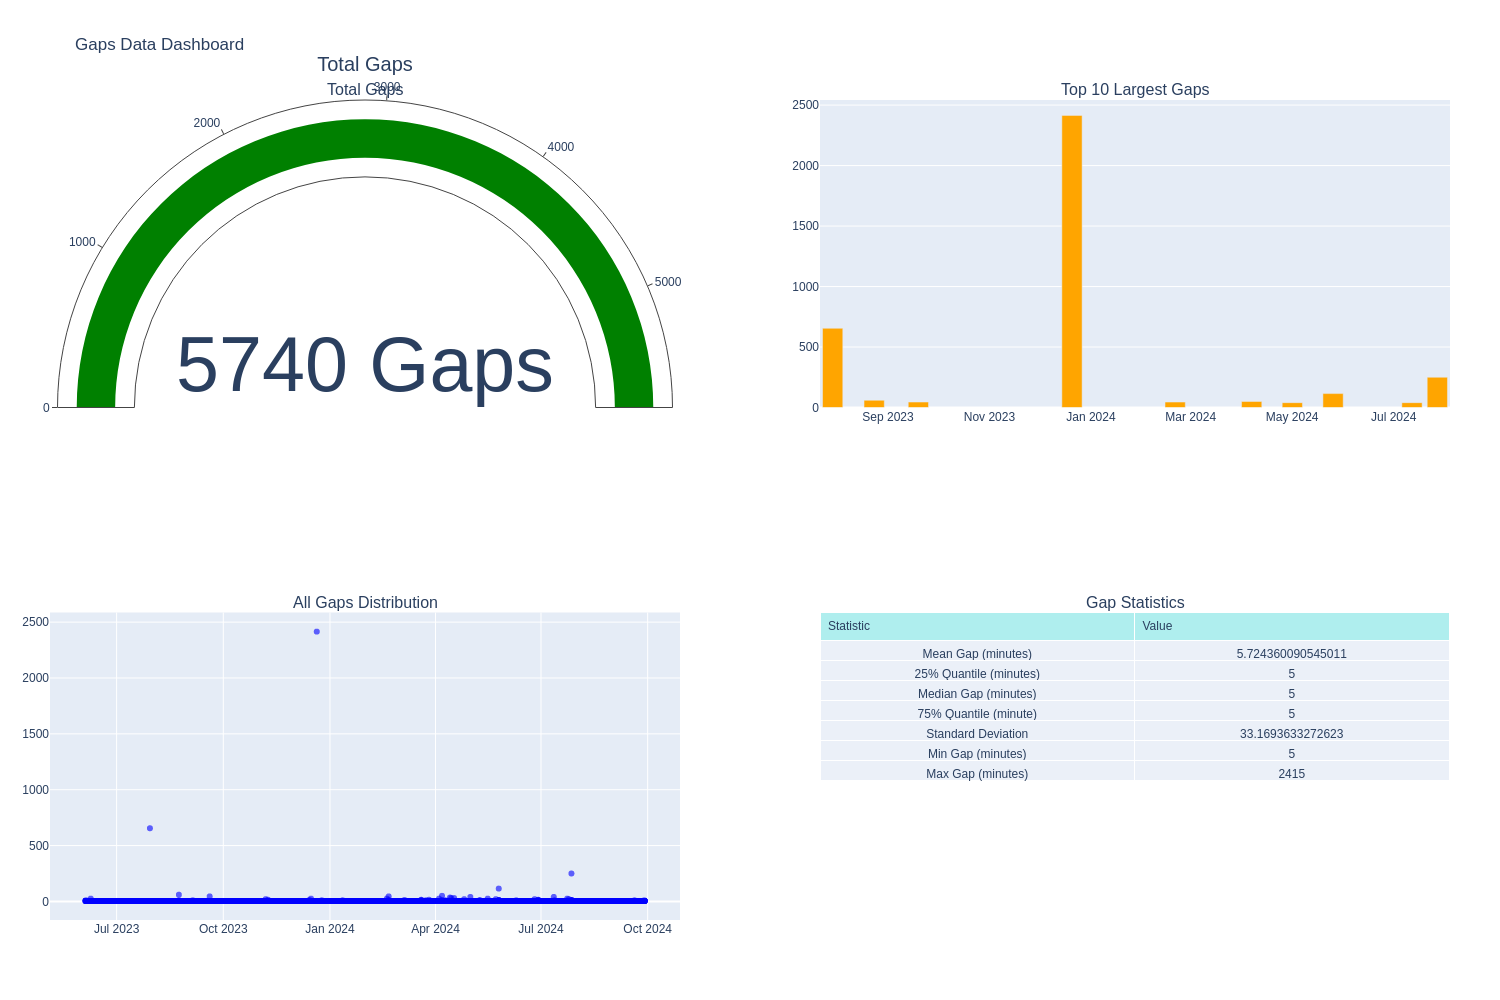

In [33]:
# Display created dashboard
display(Image(filename=path))

# Glucose Monitoring Gap Analysis Results

## Overview of Data Gaps
Our analysis identified 5,743 total gaps in glucose monitoring, with durations ranging from 5 minutes to over 40 hours. This comprehensive gap analysis reveals several key patterns:

## Gap Distribution
1. **Major Gaps** (>4 hours):
  - One exceptional gap of 40h 15m (Dec 20-22, 2023)
  - One significant gap of 10h 55m (July 29-30, 2023)
  - One moderate gap of 4h 10m (July 27, 2024)

2. **Medium Gaps** (1-4 hours):
  - Only two gaps in this range
  - Maximum of 1h 55m (May 25, 2024)
  - Minimum of 1h (Aug 23, 2023)

3. **Minor Gaps** (<1 hour):
  - Most common duration: 5 minutes
  - Several gaps between 40-50 minutes
  - Generally well-distributed across the monitoring period

## Critical Observations
1. **Meal Impact**
  - 5 of the top 10 gaps have meals in the preceding 4 hours
  - Most concerning for the 4h+ gaps affecting post-meal analysis

2. **Data Quality**
  - Majority of gaps (>5,000) are brief 5-minute interruptions
  - Only 3 gaps exceed typical meal analysis window (4 hours)
  - Overall excellent data continuity with few significant interruptions

3. **Monitoring Patterns**
  - No seasonal pattern in major gaps
  - Even distribution of minor gaps suggests routine sensor changes
  - Good recovery after interruptions

This analysis supports our decision to proceed with meal impact analysis, as the vast majority of gaps are brief and manageable with our chosen interpolation approach.

# Meal Analysis Configuration and Quality Assessment

## Data Quality Framework
We implement a structured approach for assessing meal data quality and handling glucose data gaps, with clear classification criteria and configurable parameters.

## Quality Categories
1. **Clean Meals**
   - Perfect data quality
   - No gaps in glucose readings
   - Ideal for analysis

2. **Usable Meals**
   - Small gaps (≤15 minutes)
   - Missing data ≤10%
   - Suitable for analysis after interpolation

3. **Borderline Meals**
   - Medium gaps (≤25 minutes)
   - Missing data ≤20%
   - Use with caution

4. **Unusable Meals**
   - Large gaps (>25 minutes)
   - Missing data >20%
   - Exclude from analysis

## Configuration Parameters
- Minimum meal size: 20g carbohydrates
- Post-meal analysis window: 4 hours
- Maximum interpolation: 5 consecutive readings (25 minutes)
- Clear thresholds for gap classification
- Configurable quality criteria

## Processing Workflow
1. Gap Analysis
   - Identifies missing data patterns
   - Calculates gap durations
   - Determines data completeness

2. Quality Assessment
   - Evaluates each meal period
   - Assigns quality categories
   - Marks meals for inclusion/exclusion

3. Data Enhancement
   - Interpolates acceptable gaps
   - Marks interpolated values
   - Preserves data integrity

# Meal Quality Statistics Generation

This function computes comprehensive statistics about our meal dataset quality, providing key metrics for assessing data reliability and processing effectiveness.

## Generated Statistics
The function calculates essential metrics across several dimensions:

1. **Volume Metrics**
  - Total number of meals (>20g carbs)
  - Counts per quality category
  - Percentage distribution across categories

2. **Quality Indicators**
  - Average percentage of missing data
  - Average gap duration
  - Proportion of usable meals
  - Number and percentage of interpolated points

## Statistical Output Format
Returns a dictionary containing:
- Raw counts and percentages
- Data completeness metrics
- Interpolation impact measures
- All metrics aligned with MealAnalysisConfig parameters


# Meal Quality Dashboard Generation

[`analyse_meal_data()`](../src/analysis/meals.py#L7)
[`get_meal_statistics()`](../src/analysis/meals.py#L136)
[`create_meal_statistics_dashboard()`](../src/visualisation/meal_statistics_dashboard.py#L8)

In [34]:
analysed_df = analyse_meal_data(combined_df) # Run meal quality analysis - Function in src directory

stats = get_meal_statistics(analysed_df)     # Create analysis statistics - Function in src directory

# Create and display data quality display dashboard
path = 'img/meal_statistics_dashboard.png'

fig = create_meal_statistics_dashboard(stats, save_path=path) # Create meal statistics dashboard - Function in src directory

pprint.pp(stats)

Meal Statistics Dashboard saved.
{'total_meals': 1628,
 'quality_counts': {'Usable': 1309,
                    'Clean': 170,
                    'Borderline': 137,
                    'Unusable': 12},
 'quality_percentages': {'Usable': 80.4054054054054,
                         'Clean': 10.442260442260443,
                         'Borderline': 8.415233415233416,
                         'Unusable': 0.7371007371007371},
 'avg_missing_pct': np.float64(4.550468836183122),
 'avg_gap_duration': np.float64(4.895577395577396),
 'usable_meals_pct': 99.26289926289927,
 'interpolated_points': np.int64(1808),
 'interpolated_pct': np.float64(1.3009159657214397)}


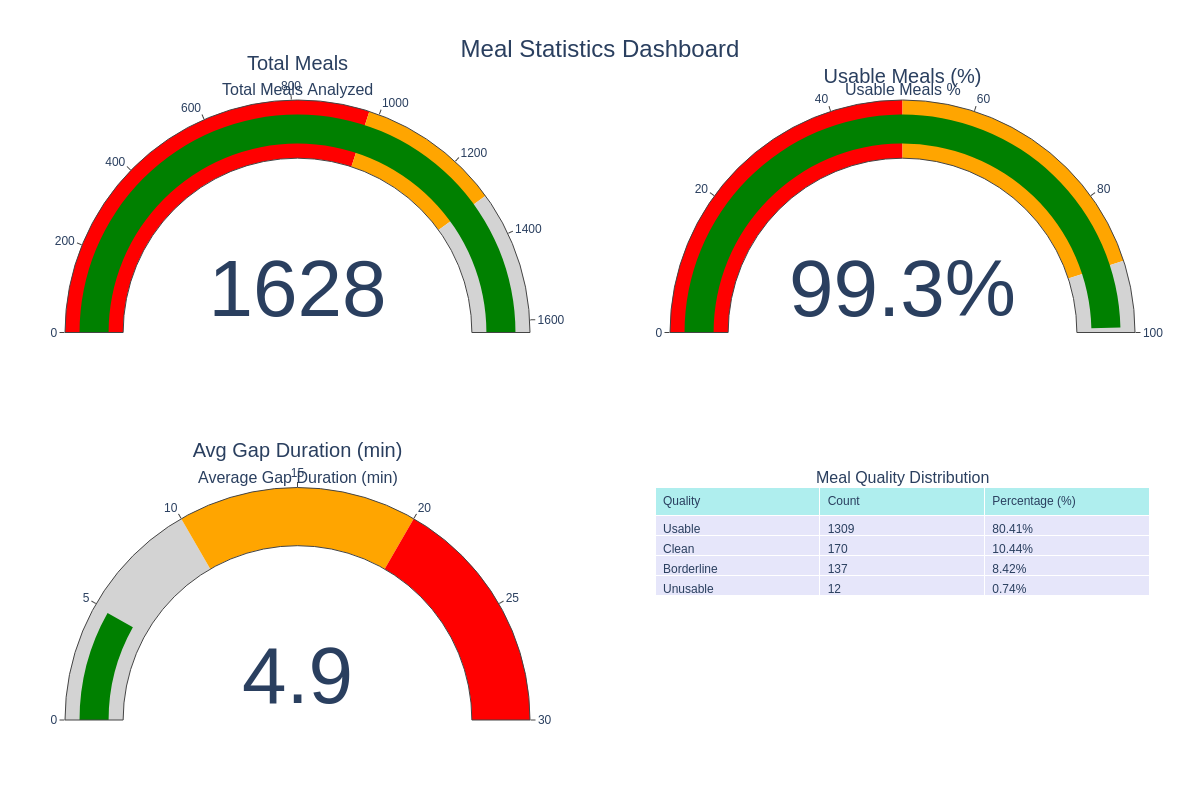

In [35]:
# Display created dashboard
display(Image(filename=path))

# Meal Analysis Results Summary

## Dataset Overview
Analysis of 1,628 meals (>20g carbs) reveals excellent data quality with high usability for gastroparesis screening:

## Quality Distribution
- **Clean Meals**: 170 (10.44%)
 * Perfect data quality
 * No interpolation needed
- **Usable Meals**: 1,309 (80.41%)
 * Primary analysis dataset
 * Minor gaps successfully interpolated
- **Borderline Meals**: 137 (8.42%)
 * Usable with caution
 * Higher but acceptable gap rates
- **Unusable Meals**: 12 (0.74%)
 * Excluded from analysis
 * Excessive missing data

## Data Quality Metrics
1. **Gap Characteristics**
  - Average gap duration: 4.90 minutes
  - Average missing data: 4.55%
  - Both well within acceptable limits

2. **Interpolation Impact**
  - 1,808 points interpolated
  - Only 1.30% of total readings
  - Minimal data manipulation required

3. **Overall Usability**
  - 99.26% of meals usable for analysis
  - Strong foundation for gastroparesis screening
  - High confidence in data integrity

These results indicate exceptional data quality with minimal need for interpolation, providing a robust dataset for subsequent analysis.

# Dataset Structure and Statistical Summary

## Dataset Properties Analysis
After meal quality analysis and interpolation, let's examine our complete dataset structure and statistical distribution.

## Data Structure
Let's examine:
1. Total records and memory usage
2. Column data types
3. Non-null counts
4. Index structure and timeline coverage

## Statistical Distribution
The describe() output provides key statistics for each column:
1. Central tendency (mean, std)
2. Range and quartiles
3. Treatment frequency and size
4. Glucose value distribution

This verification ensures our processing maintained data integrity while improving usability.

In [36]:
analysed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138979 entries, 2023-06-03 22:30:00 to 2024-09-28 12:00:00
Freq: 5min
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   mg_dl              134925 non-null  float64
 1   mmol_l             134925 non-null  float64
 2   carbs              138979 non-null  float64
 3   bolus              138979 non-null  float64
 4   basal              138979 non-null  float64
 5   has_missing_data   138979 non-null  bool   
 6   gap_duration_mins  138979 non-null  float64
 7   missing_pct        138979 non-null  float64
 8   meal_quality       1628 non-null    object 
 9   skip_meal          138979 non-null  bool   
 10  interpolated       138979 non-null  bool   
dtypes: bool(3), float64(7), object(1)
memory usage: 14.0+ MB


In [37]:
analysed_df.describe()

,mg_dl,mmol_l,carbs,bolus,basal,gap_duration_mins,missing_pct
count,134925.000000,134925.000000,138979.000000,138979.000000,138979.000000,138979.000000,138979.000000
mean,118.761766,6.591278,0.665620,0.106231,0.039092,0.057347,0.053304
std,53.405889,2.964027,5.257466,0.710322,0.679371,0.808486,0.683813
min,39.640000,2.200020,0.000000,0.000000,0.000000,0.000000,0.000000
25%,81.687730,4.533669,0.000000,0.000000,0.000000,0.000000,0.000000
50%,110.187646,6.115414,0.000000,0.000000,0.000000,0.000000,0.000000
75%,144.341367,8.010946,0.000000,0.000000,0.000000,0.000000,0.000000
max,360.360000,19.999980,140.000000,16.000000,15.000000,125.000000,73.469388


# Diabetes Data Processing and Meal Analysis Summary

## Initial Data Processing
We started with three separate dataframes extracted from xDrip+ CGM management software:
- Blood glucose readings (mg/dl and mmol/l) at approximately 5-minute intervals
- Carbohydrate intake records
- Insulin (bolus and basal) records processed from treatment logs

## Data Alignment and Quality Analysis
1. Aligned all data to regular 5-minute intervals
2. Created a meal analysis framework with configurable parameters:
  - 4-hour post-meal analysis windows
  - Minimum 20g carbs to consider as significant meal
  - Maximum gap tolerance of 25 minutes
  - Maximum 20% missing data allowed
  - Interpolation limit of 25 minutes (5 readings)

## Quality Metrics and Results
Our analysis of 1,628 significant meals (>20g carbs) shows:
- 170 Clean meals (10.44%): Perfect data, no gaps
- 1,309 Usable meals (80.41%): Small gaps only, ≤10% missing
- 137 Borderline meals (8.42%): Medium gaps, ≤20% missing
- Only 12 Unusable meals (0.74%): Large gaps or excessive missing data

The data quality is excellent:
- 99.26% of meals are usable for analysis
- Average missing data is only 4.55%
- Average gap duration is 4.90 minutes
- Only 1.30% of points needed interpolation (1,808 points)

## New Dataset Features
The processed dataframe includes additional columns crucial for gastroparesis screening:
- has_missing_data: Flags any missing BG in 4h post-meal, crucial for response curve integrity
- gap_duration_mins: Longest gap in post-meal period, important for meal absorption analysis
- missing_pct: Percentage of missing readings, validates data quality
- meal_quality: Clean/Usable/Borderline/Unusable, enables filtered analysis
- skip_meal: Boolean for excluding from analysis, maintains data quality standards
- interpolated: Marks interpolated values, ensures transparency in analysis

## Important Notes
1. All original data is preserved - no rows have been removed
2. Small gaps have been interpolated where appropriate
3. Quality markers allow easy filtering for analysis
4. 20g carbohydrate threshold ensures significant meal impacts
5. Data structure supports comprehensive meal response analysis

## Next Steps
While the data is now well-organized and quality-assessed, specific gastroparesis analysis may require:
- Meal size stratification analysis (varying carbohydrate loads)
- Time-of-day impact assessment on gastric emptying
- Insulin timing relationship with meal absorption
- Sensor type and calibration effects on readings
- Additional meal characteristic analysis
- Specific time window selections for different meal types
- Additional derived features for absorption patterns
- Custom filtering based on research requirements

This processed dataset provides a robust foundation for investigating gastric motility patterns through post-meal glucose responses.

[`display_quality_metrics()`](../src/analysis/metrics.py#L5)
[`creatte_quality_dashboard()`](../src/visualisation/quality_dashboard.py#L8)

In [38]:
# Display detailed metrics
metrics = display_quality_metrics(analysed_df) # Function can be found in src directory
metrics

{'total_readings': 138979,
 'complete_readings': np.int64(134925),
 'completeness_rate': np.float64(97.08301254146309),
 'interpolated_points': np.int64(1808),
 'interpolation_rate': np.float64(1.3009159657214397),
 'average_gap_duration': np.float64(0.05734679340044179),
 'max_gap_duration': np.float64(125.0),
 'total_meals': 1628,
 'meal_quality_distribution': {'Usable': 1309,
  'Clean': 170,
  'Borderline': 137,
  'Unusable': 12}}

Data Quality Dashboard saved


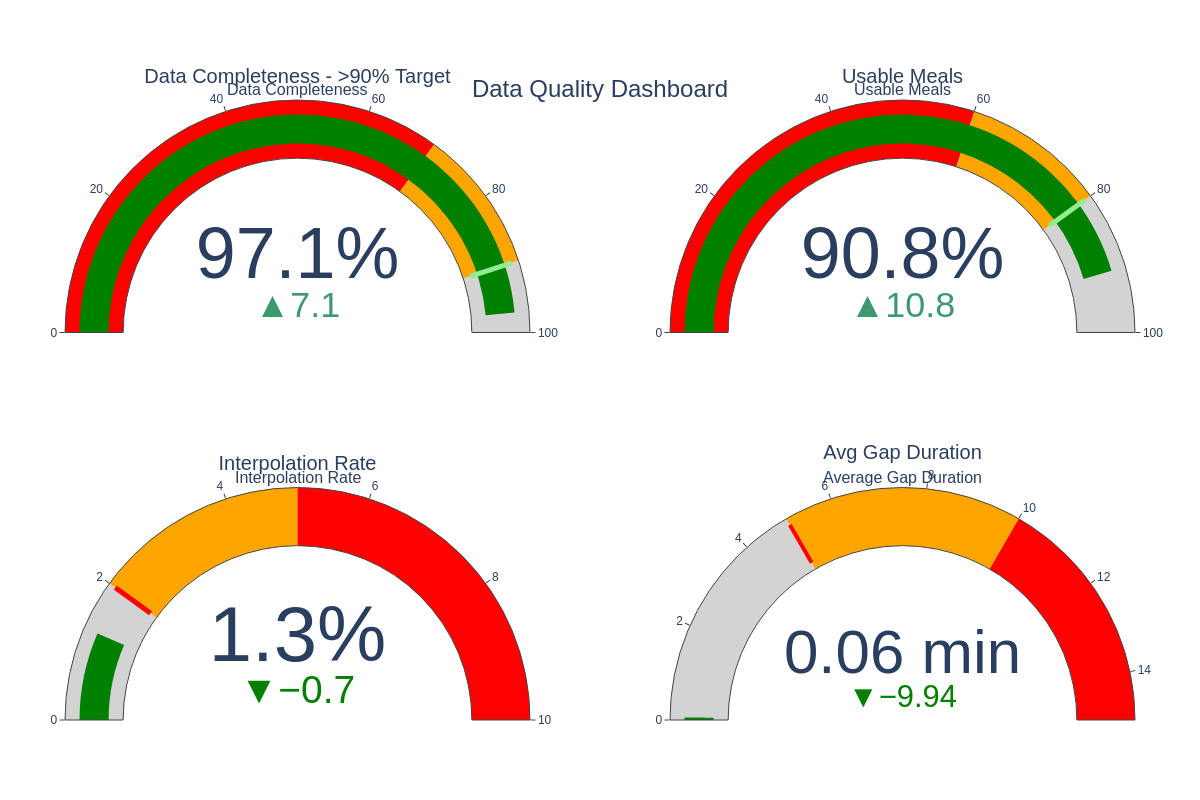

In [39]:
# Create and display data quality display dashboard
path = 'img/output_dashboard.png'
fig = create_quality_dashboard(analysed_df, save_path=path)

# Display created dashboard
display(Image(filename=path))

In [40]:
# Save dataframe to CSV file for future use
analysed_df.to_csv('../../data/processed_data.csv')